# Import all the libraries required and cofiguring the GPU

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import math
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Import a pre-trained model from keras using the weights from ImageNet


In [3]:
img_width, img_height = 224, 224 #Set the image size
#Check the picture layout
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
#Save the imported model in variable called base_model
base_model=tf.keras.applications.ResNet101V2(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet",
)

#Freez the layers in order to not lose the weights
for layer in base_model.layers:
        layer.trainable = False  

# Use Image data generator for data augmentation

In [4]:
train_data_dir = 'D:/University 3rd year/Dissertation/Code/Training_data_c'#Instantiate the path for training dataset
test_data_dir = 'D:/University 3rd year/Dissertation/Code/Testing_data_c'#Instantiate the path for validation dataset
batch_size = 128

#Set the variables for data augmentation
train_datagen = ImageDataGenerator(
       rescale=1./255,
        zoom_range=0.1,
        validation_split=0.2,
        rotation_range=5,
        horizontal_flip=True)

#Apply data augmentation on validation set
test_datagen = ImageDataGenerator(
       rescale=1./255)

training_set = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        subset='training',
        class_mode='categorical')
 
#Apply data augmentation on validation set
test_set= test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset='validation',
        shuffle = False,
        class_mode='categorical')
 

test_set.class_indices #Print the classes

Found 283901 images belonging to 7 classes.
Found 3500 images belonging to 7 classes.


{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Add the layers and parameters to the model

In [7]:
num_classes = 7 #Set the number of output neurons

                        
base_input=base_model.layers[0].input #Save the layers of the pre-trained model
base_output=base_model.layers[-1].output #Save the output of the last layer
    
#Add convolutional layer with 512 neurons 3*3 filter and l2 regularization
final_output=layers.Conv2D(512, kernel_size=(3,3), padding="same",kernel_regularizer=l2(3.6595e-05))(base_output)
final_output=layers.BatchNormalization()(final_output)#Add batch normalization
final_output=tf.keras.layers.ReLU()(final_output)#Add activation function
    
#Add convolutional layer with 64 neurons 3*3 filter and l2 regularization
final_output=layers.Conv2D(64, kernel_size=(3,3), padding="same",kernel_regularizer=l2(0.008451 ))(final_output)
final_output=layers.BatchNormalization()(final_output)#Add batch normalization
final_output=tf.keras.layers.ReLU()(final_output)#Add activation function

final_output=layers.GlobalMaxPooling2D(data_format='channels_last')(final_output)#Add GlobalMaxPoolig layer

final_output=layers.Dropout(0.2)(final_output) #Add a Dropout layer
final_output=layers.Flatten()(final_output) # Add Flatten layer

  
#Add a fully conceted layer with 384 neurons and l2 regularization
final_output=layers.Dense(384,kernel_regularizer=l2(3.9885e-05))(final_output)
final_output=layers.BatchNormalization()(final_output)#Add batch normalization
final_output=tf.keras.layers.ReLU()(final_output)#Add activation function


final_output=layers.Dense(num_classes,activation='softmax')(final_output)#Add output layer with neurons for each class


new_model=tf.keras.Model(inputs=base_input,outputs=final_output)#Add the new layers to the model
new_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])#Compile the model using adam optimizer
new_model.summary()# Print the model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

# Train the model for 50 epochs and save the best weights using ModelCheckpoint

In [8]:
model = new_model
#Create a folder with the best models
directory='Checkpoint_Resnet101V2-V10'
name='Model'
saved = os.path.join(directory, name + "-{epoch:02d}.h5")
#Set up the ModelChepoint
callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=saved, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
)
#Train the model
history=model.fit(training_set,
        epochs=50,
        callbacks=callback,
        steps_per_epoch=227124 // batch_size,
        validation_data=test_set,
        validation_steps= 56777 // batch_size)

Epoch 1/50
2217/2217 [==============================] - 2844s 1s/step - loss: 1.2701 - accuracy: 0.6435 - val_loss: 2.1280 - val_accuracy: 0.3449
Epoch 2/50
2217/2217 [==============================] - 2816s 1s/step - loss: 0.9976 - accuracy: 0.6865 - val_loss: 1.9361 - val_accuracy: 0.3898
Epoch 3/50
2217/2217 [==============================] - 2811s 1s/step - loss: 0.9538 - accuracy: 0.6973 - val_loss: 1.9536 - val_accuracy: 0.3851
Epoch 4/50
2217/2217 [==============================] - 2828s 1s/step - loss: 0.9282 - accuracy: 0.7021 - val_loss: 1.8187 - val_accuracy: 0.4120
Epoch 5/50
2217/2217 [==============================] - 2805s 1s/step - loss: 0.8988 - accuracy: 0.7090 - val_loss: 1.8187 - val_accuracy: 0.4086
Epoch 6/50
2217/2217 [==============================] - 2794s 1s/step - loss: 0.8842 - accuracy: 0.7091 - val_loss: 1.8072 - val_accuracy: 0.4245
Epoch 7/50
2217/2217 [==============================] - 2808s 1s/step - loss: 0.8715 - accuracy: 0.7135 - val_loss: 1.9157 -

# Plot the accuracy and cross-entropy diagrams

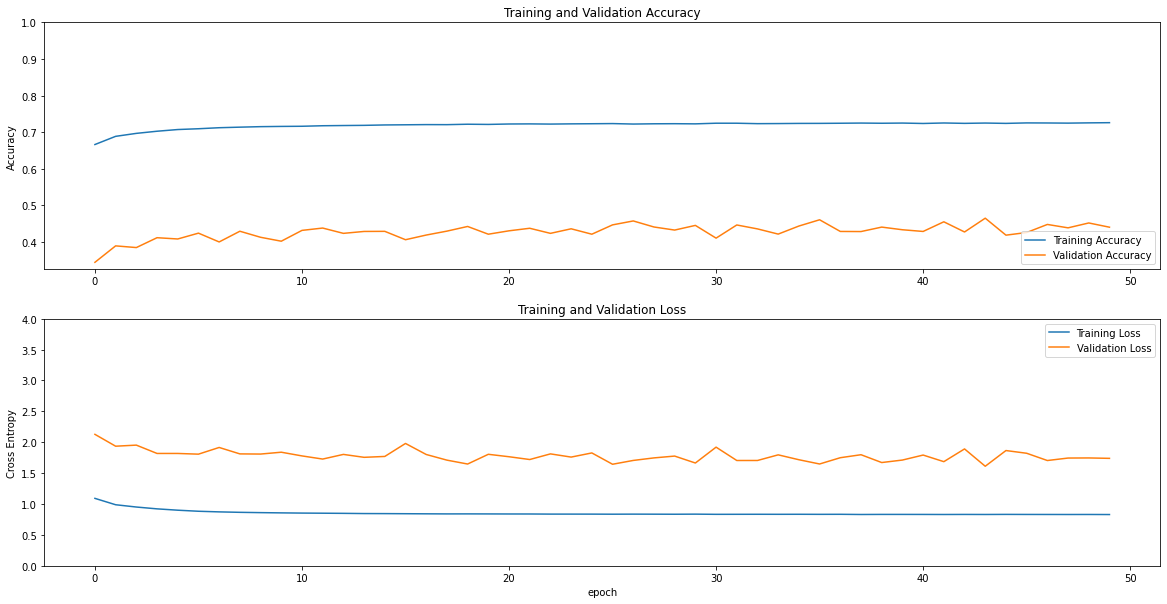

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()